# Governing equations in the QG system
Vorticity equation in Layer 1:
$$
\frac{\partial \zeta _{g1}}{\partial t} = -u_{g1}\frac{\partial \zeta _{g1}}{\partial x} -v_{g1}\frac{\partial \zeta _{g1}}{\partial y} -\beta v_{g1}+\omega _2\frac{f_0}{\delta p} 
$$

Vorticity equation in Layer 3:
$$
\frac{\partial \zeta _{g3}}{\partial t} = -u_{g3}\frac{\partial \zeta _{g3}}{\partial x} -v_{g3}\frac{\partial \zeta _{g3}}{\partial y} -\beta v_{g3}-\omega _2\frac{f_0}{\delta p} 
$$

Thermodynamic equation in Layer 2:
$$
\frac{\partial T_2}{\partial t} = -u_2\frac{\partial T_2}{\partial x} -v_2\frac{\partial T_2}{\partial y} -\frac{\sigma}{f_0} \omega _2
$$

Diagnostic equation of $\psi $ from $\zeta $:
$$
\zeta \equiv \frac{\partial ^2\psi}{\partial x^2} +\frac{\partial ^2\psi}{\partial y^2} =\frac{1}{f_0} \left(\frac{\partial ^2\phi}{\partial x^2} +\frac{\partial ^2\phi}{\partial y^2} \right)
$$

Geostrophic flows of variables ($u_g$ and $v_g$) in each layer: 
$$
f_0v_g=\frac{\partial \phi}{\partial x} ,\quad f_0u_g=-\frac{\partial \phi}{\partial y} 
$$

Diagnostic equation of $\psi $ from $T$: 
$$
T \equiv \frac{\psi _3-\psi _1}{\delta p} 
$$

Diagnostic equation of variables ($A_1$) in Layer 2: 
$$
A_2\equiv \frac{A_1+A_3}{2} 
$$

# Boundary conditions
Bottom and top boundaries for $\omega $: 
$$
\omega _0=\omega _4=0
$$

# Discretization
Finite differencing with the Arakawa Jacobian: 

Time integration with the RK4:

Relationship of $\psi $ and $\zeta $ at $x_i$ and $y_j$: 
$$
\zeta _{i,j}=\dfrac{\psi_{i+1,j}+\psi_{i-1,j}-2\psi_{i,j}}{\Delta x^2} +\dfrac{\psi_{i,j+1}+\psi_{i,j-1}-2\psi_{i,j}}{\Delta y^2} =\dfrac{1}{\Delta x^2} \psi_{i+1,j}+\dfrac{1}{\Delta x^2} \psi_{i-1,j}+\dfrac{1}{\Delta y^2} \psi_{i,j+1}+\dfrac{1}{\Delta y^2} \psi_{i,j-1}-2\left(\dfrac{1}{\Delta x^2} +\dfrac{1}{\Delta y^2} \right) \psi_{i,j}
$$

# Procedures in the model
1. Calculation $\zeta $ to $\psi $
2. Time integration of the tendency equations


In [3]:
include("./QG_solvers.jl")
using .QG_solvers
using Random

nx = 100
ny = 100
nz = 1
nt = 20000
#nt = 1000
ntr = 10000
emax = 1.0e-6
nu = 2.0e-12
dmpitv = 200

zeta1 = reshape(zeros(nx,ny),nx,ny)
zeta_dmp = reshape(zeros(nx,ny,(nt÷dmpitv)+1),nx,ny,(nt÷dmpitv)+1)

#zeta[nx÷2,ny÷2] = 1.0

rng = MersenneTwister(1234)

#for j in 1:ny
#    for i in 1:nx
#        zeta1[i,j] = randn(rng,Float64)  # Normal distribution
#    end
#end
zeta1[2:nx-1,2:ny-1] = rand(Float64,(nx-2)*(ny-2))

zeta_max = zeta1[findall(isequal(maximum(zeta1)),zeta1)]

zeta1[2:nx-1,2:ny-1] .= zeta1[2:nx-1,2:ny-1] / zeta_max[1] .- 0.5

xmin = 0.0
xmax = 2.0 * pi
ymin = 0.0
ymax = 2.0 * pi
zmin = 0.0
zmax = 2.0 * pi

x = reshape(zeros(nx),nx)
y = reshape(zeros(ny),ny)
z = reshape(zeros(nz),nz)
psi1 = reshape(zeros(nx,ny),nx,ny)
psi2 = reshape(zeros(nx,ny),nx,ny)
psi = reshape(zeros(nx,ny,nz),nx,ny,nz)
zeta = reshape(zeros(nx,ny,nz),nx,ny,nz)

for i in 1:nx
    x[i] = xmin + (xmax-xmin) * (i-1) / (nx-1)
end
for i in 1:ny
    y[i] = ymin + (ymax-ymin) * (i-1) / (ny-1)
end
for i in 1:nz
    z[i] = zmin + (zmax-zmin) * (i-1) / (nz-1)
end

dx = (xmax-xmin) / (nx-1)
dy = (ymax-ymin) / (ny-1)
dz = (zmax-zmin) / (nz-1)
dt = 0.05
dmpcount = 1

#psi1 = zeta_to_psi1( dx, dy, nx, ny, zeta )
psi2 = zeta_to_psi2( ntr, emax, dx, dy, nx, ny, zeta1, psi2 )
psi1 = zeta_to_psi2( ntr, emax, dx, dy, nx, ny, zeta1, psi2 )
psi[1:nx,1:ny,1:nz] = psi2[1:nx,1:ny]
zeta[1:nx,1:ny,1:nz] = zeta1[1:nx,1:ny]

zeta_dmp[1:nx,1:ny,dmpcount] = zeta[1:nx,1:ny,1]
# Time integration
for i in 1:nt
    zeta_new, psi_new = integrate_RK4( nu, 10000, emax, dx, dy, dz, nx, ny, nz, zeta, psi, dt )
    zeta_max = zeta_new[findall(isequal(maximum(zeta_new)),zeta_new)]
    println( "zeta max = ", zeta_max )
    zeta = zeta_new
    psi = psi_new
    println("i = ", i)
    if mod(i,dmpitv) == 0
        dmpcount = dmpcount + 1
        zeta_dmp[1:nx,1:ny,dmpcount] .= zeta[1:nx,1:ny,1]
    end
end

zeta max = 

[0.5009312095599575]
i = 1
zeta max = [0.5037420913590495]
i = 2
zeta max = [0.5065517213047804]
i = 3
zeta max = [0.5093519892341505]
i = 4
zeta max = [0.5121400098802028]
i = 5
zeta max = [0.514912646713824]
i = 6
zeta max = [0.5176717358501819]
i = 7
zeta max = [0.5204153870547783]
i = 8
zeta max = [0.5231465534578105]
i = 9
zeta max = [0.5258655378416112]
i = 10
zeta max = [0.5285690355898465]
i = 11
zeta max = [0.5312521835004753]
i = 12
zeta max = [0.5339198290139936]
i = 13
zeta max = [0.5365700376575736]
i = 14
zeta max = [0.5392082715958939]
i = 15
zeta max = [0.5418317675356532]
i = 16
zeta max = [0.5444371829182385]
i = 17
zeta max = [0.5470264135167361]
i = 18
zeta max = [0.5495970262191145]
i = 19
zeta max = [0.5521518105460262]
i = 20
zeta max = [0.554689796670481]
i = 21
zeta max = [0.5572094934392942]
i = 22
zeta max = [0.5599139852847412]
i = 23
zeta max = [0.5626373717402751]
i = 24
zeta max = [0.5653560856754432]
i = 25
zeta max = [0.568069278003854]
i = 26
zeta max 

zeta max = [0.9546064957748622]
i = 210
zeta max = [0.9554518050866954]
i = 211
zeta max = [0.956246877878109]
i = 212
zeta max = [0.9569927158919244]
i = 213
zeta max = [0.9576884196249171]
i = 214
zeta max = [0.958334209278085]
i = 215
zeta max = [0.9589299545498831]
i = 216
zeta max = [0.9594755199980333]
i = 217
zeta max = [0.9599709931617945]
i = 218
zeta max = [0.9604161437234605]
i = 219
zeta max = [0.960810415180243]
i = 220
zeta max = [0.9611546410457378]
i = 221
zeta max = [0.9614491031312873]
i = 222
zeta max = [0.9616939367955276]
i = 223
zeta max = [0.9618883258283034]
i = 224
zeta max = [0.9620328369337118]
i = 225
zeta max = [0.9621275369452353]
i = 226
zeta max = [0.962172425921424]
i = 227
zeta max = [0.9621671114471207]
i = 228
zeta max = [0.9621118429264558]
i = 229
zeta max = [0.9620065280202852]
i = 230
zeta max = [0.9618511695184152]
i = 231
zeta max = [0.9616459434061921]
i = 232
zeta max = [0.9613907775219951]
i = 233
zeta max = [0.9610857239114847]
i = 234
zeta

zeta max = [0.9955775796205387]
i = 416
zeta max = [0.9957159509091428]
i = 417
zeta max = [0.9958500981633112]
i = 418
zeta max = [0.9959801213614686]
i = 419
zeta max = [0.9961058404102203]
i = 420
zeta max = [0.9962273033580243]
i = 421
zeta max = [0.9963431479814113]
i = 422
zeta max = [0.9964544352233723]
i = 423
zeta max = [0.9965617425589465]
i = 424
zeta max = [0.9966641649635122]
i = 425
zeta max = [0.9967622152097411]
i = 426
zeta max = [0.9968556026212118]
i = 427
zeta max = [0.9969435683491596]
i = 428
zeta max = [0.9970279941035611]
i = 429
zeta max = [0.9971072470457051]
i = 430
zeta max = [0.9971826225817549]
i = 431
zeta max = [0.9972537297406443]
i = 432
zeta max = [0.9973205909055698]
i = 433
zeta max = [0.9973832117948019]
i = 434
zeta max = [0.9974417476407798]
i = 435
zeta max = [0.9974957964818076]
i = 436
zeta max = [0.9975457694008086]
i = 437
zeta max = [0.9975905559133922]
i = 438
zeta max = [0.99763151102485]
i = 439
zeta max = [0.9976681100217575]
i = 440
ze

zeta max = [0.9418412750462878]
i = 622
zeta max = [0.9412146116512133]
i = 623
zeta max = [0.9405837455654029]
i = 624
zeta max = [0.9399500682774827]
i = 625
zeta max = [0.9393133730128069]
i = 626
zeta max = [0.9386740740792502]
i = 627
zeta max = [0.93803124928776]
i = 628
zeta max = [0.9373851088353706]
i = 629
zeta max = [0.9367360438504081]
i = 630
zeta max = [0.9360838100984722]
i = 631
zeta max = [0.9354295001488231]
i = 632
zeta max = [0.9347726497861988]
i = 633
zeta max = [0.9341122798333706]
i = 634
zeta max = [0.93344634554823]
i = 635
zeta max = [0.932775324535059]
i = 636
zeta max = [0.9321014465909156]
i = 637
zeta max = [0.9314273005431717]
i = 638
zeta max = [0.9307475896750442]
i = 639
zeta max = [0.930063586791334]
i = 640
zeta max = [0.9293760410706976]
i = 641
zeta max = [0.9286846406737806]
i = 642
zeta max = [0.9279915867622015]
i = 643
zeta max = [0.9272943854302781]
i = 644
zeta max = [0.9265938038157865]
i = 645
zeta max = [0.9258898059964014]
i = 646
zeta m

zeta max = [0.8493214092179634]
i = 828
zeta max = [0.8480643842353597]
i = 829
zeta max = [0.8467933420105808]
i = 830
zeta max = [0.845509705778956]
i = 831
zeta max = [0.8442086439526069]
i = 832
zeta max = [0.8428953515231021]
i = 833
zeta max = [0.8415698186334984]
i = 834
zeta max = [0.840228949191762]
i = 835
zeta max = [0.8388764811400068]
i = 836
zeta max = [0.8375077645171667]
i = 837
zeta max = [0.8361280349841447]
i = 838
zeta max = [0.8347325071898364]
i = 839
zeta max = [0.8333240525487516]
i = 840
zeta max = [0.8328824362062923]
i = 841
zeta max = [0.8327539656556765]
i = 842
zeta max = [0.8326207908791406]
i = 843
zeta max = [0.8324839734917645]
i = 844
zeta max = [0.8323416570087424]
i = 845
zeta max = [0.8321939761724905]
i = 846
zeta max = [0.8320412009734689]
i = 847
zeta max = [0.8318826904440826]
i = 848
zeta max = [0.8317204297909111]
i = 849
zeta max = [0.8315531961201186]
i = 850
zeta max = [0.8313805712413096]
i = 851
zeta max = [0.8312035391518131]
i = 852
ze

zeta max = [0.8297129593444916]
i = 1033
zeta max = [0.8296726762287934]
i = 1034
zeta max = [0.8296312450699374]
i = 1035
zeta max = [0.829588702008096]
i = 1036
zeta max = [0.8295455442216603]
i = 1037
zeta max = [0.8295015430746863]
i = 1038
zeta max = [0.8294569391912874]
i = 1039
zeta max = [0.8294116147589213]
i = 1040
zeta max = [0.8293654033170691]
i = 1041
zeta max = [0.8293183636657065]
i = 1042
zeta max = [0.8292705338209952]
i = 1043
zeta max = [0.8292214710076893]
i = 1044
zeta max = [0.8291717298583795]
i = 1045
zeta max = [0.8291210811806277]
i = 1046
zeta max = [0.8290696235610465]
i = 1047
zeta max = [0.8290170882348303]
i = 1048
zeta max = [0.8289630258685684]
i = 1049
zeta max = [0.8289077547907728]
i = 1050
zeta max = [0.8288516791139063]
i = 1051
zeta max = [0.8287947458745506]
i = 1052
zeta max = [0.8287371057177547]
i = 1053
zeta max = [0.8286785631735416]
i = 1054
zeta max = [0.8286192890274464]
i = 1055
zeta max = [0.8285587331254528]
i = 1056
zeta max = [0.828

zeta max = [0.8493507921902721]
i = 1234
zeta max = [0.849761290998403]
i = 1235
zeta max = [0.850165331779605]
i = 1236
zeta max = [0.8505625159098084]
i = 1237
zeta max = [0.8509530552803132]
i = 1238
zeta max = [0.8513368839919865]
i = 1239
zeta max = [0.8517137309388141]
i = 1240
zeta max = [0.8520837766589405]
i = 1241
zeta max = [0.8524471685434396]
i = 1242
zeta max = [0.8528043853912193]
i = 1243
zeta max = [0.8531554557473014]
i = 1244
zeta max = [0.8534991427672575]
i = 1245
zeta max = [0.8538355782008799]
i = 1246
zeta max = [0.8541663720935442]
i = 1247
zeta max = [0.8544913243947173]
i = 1248
zeta max = [0.8548103264385324]
i = 1249
zeta max = [0.8551227450598803]
i = 1250
zeta max = [0.8554282455610294]
i = 1251
zeta max = [0.8557273631018854]
i = 1252
zeta max = [0.8560206532966598]
i = 1253
zeta max = [0.8563076264922547]
i = 1254
zeta max = [0.8565892248712391]
i = 1255
zeta max = [0.8568650717333425]
i = 1256
zeta max = [0.8571347555211826]
i = 1257
zeta max = [0.8573

zeta max = [0.9312940239472584]
i = 1435
zeta max = [0.931620212192974]
i = 1436
zeta max = [0.9319428552544566]
i = 1437
zeta max = [0.9322632712647618]
i = 1438
zeta max = [0.9325794052514814]
i = 1439
zeta max = [0.932892716990096]
i = 1440
zeta max = [0.9332020377874267]
i = 1441
zeta max = [0.9335086003269795]
i = 1442
zeta max = [0.933812176784791]
i = 1443
zeta max = [0.93411223845585]
i = 1444
zeta max = [0.9344097781713326]
i = 1445
zeta max = [0.9347038144054195]
i = 1446
zeta max = [0.9349947464498707]
i = 1447
zeta max = [0.935282677794301]
i = 1448
zeta max = [0.9355677322641117]
i = 1449
zeta max = [0.9358486044889319]
i = 1450
zeta max = [0.9361266829918071]
i = 1451
zeta max = [0.9364015563660925]
i = 1452
zeta max = [0.9366732719410304]
i = 1453
zeta max = [0.9369408856954613]
i = 1454
zeta max = [0.9372050653644376]
i = 1455
zeta max = [0.9374660305548053]
i = 1456
zeta max = [0.9377239269993851]
i = 1457
zeta max = [0.9379792957677335]
i = 1458
zeta max = [0.93823022

zeta max = [0.9049252397443641]
i = 1636
zeta max = [0.904138527758522]
i = 1637
zeta max = [0.9033435713722112]
i = 1638
zeta max = [0.9025401956656115]
i = 1639
zeta max = [0.90172848718752]
i = 1640
zeta max = [0.9009081997207854]
i = 1641
zeta max = [0.9000793476840013]
i = 1642
zeta max = [0.8992419200443988]
i = 1643
zeta max = [0.898395783001838]
i = 1644
zeta max = [0.8975407722451212]
i = 1645
zeta max = [0.8966769413155343]
i = 1646
zeta max = [0.8958043895231428]
i = 1647
zeta max = [0.8949231770889776]
i = 1648
zeta max = [0.8940333243717651]
i = 1649
zeta max = [0.8931350747861752]
i = 1650
zeta max = [0.8922283425077195]
i = 1651
zeta max = [0.8913130097235752]
i = 1652
zeta max = [0.8903889833304125]
i = 1653
zeta max = [0.889456075627938]
i = 1654
zeta max = [0.8885143933883294]
i = 1655
zeta max = [0.8875641244928792]
i = 1656
zeta max = [0.8866051512833021]
i = 1657
zeta max = [0.8856374492669005]
i = 1658
zeta max = [0.8846608446409906]
i = 1659
zeta max = [0.8836752

zeta max = [0.8212845647760967]
i = 1837
zeta max = [0.8213707241860837]
i = 1838
zeta max = [0.8214576413320028]
i = 1839
zeta max = [0.8215436593915011]
i = 1840
zeta max = [0.8216301143990363]
i = 1841
zeta max = [0.8217157711532898]
i = 1842
zeta max = [0.821801598892163]
i = 1843
zeta max = [0.8218867306098494]
i = 1844
zeta max = [0.8219724141184624]
i = 1845
zeta max = [0.8220584356935737]
i = 1846
zeta max = [0.8221436972408979]
i = 1847
zeta max = [0.822228014932275]
i = 1848
zeta max = [0.8223126039165172]
i = 1849
zeta max = [0.8223973594849693]
i = 1850
zeta max = [0.8224813630431275]
i = 1851
zeta max = [0.8225662402474538]
i = 1852
zeta max = [0.8226505814035514]
i = 1853
zeta max = [0.8227339810466925]
i = 1854
zeta max = [0.8228171885125151]
i = 1855
zeta max = [0.822900880407076]
i = 1856
zeta max = [0.8229841743223111]
i = 1857
zeta max = [0.823067074699355]
i = 1858
zeta max = [0.8231492945432161]
i = 1859
zeta max = [0.8232332440810927]
i = 1860
zeta max = [0.823314

zeta max = [0.8409715939581381]
i = 2237
zeta max = [0.8406156950125756]
i = 2238
zeta max = [0.8402553568964]
i = 2239
zeta max = [0.8398906216441249]
i = 2240
zeta max = [0.8395215347904583]
i = 2241
zeta max = [0.8391481390189887]
i = 2242
zeta max = [0.8387704750771824]
i = 2243
zeta max = [0.8383885747032613]
i = 2244
zeta max = [0.8380024876225128]
i = 2245
zeta max = [0.8376122515314419]
i = 2246
zeta max = [0.837217890504971]
i = 2247
zeta max = [0.8368194564515541]
i = 2248
zeta max = [0.8364169788345176]
i = 2249
zeta max = [0.8360105149350179]
i = 2250
zeta max = [0.835600108435482]
i = 2251
zeta max = [0.8351857829577385]
i = 2252
zeta max = [0.8347675889084436]
i = 2253
zeta max = [0.8343455706933225]
i = 2254
zeta max = [0.8339197550917445]
i = 2255
zeta max = [0.8334901795436293]
i = 2256
zeta max = [0.8330568859380038]
i = 2257
zeta max = [0.8326199183121726]
i = 2258
zeta max = [0.8321793061067988]
i = 2259
zeta max = [0.8317351105760222]
i = 2260
zeta max = [0.8312873

zeta max = [0.8812324465609502]
i = 2438
zeta max = [0.881185278179837]
i = 2439
zeta max = [0.8811321053878753]
i = 2440
zeta max = [0.8810732842810226]
i = 2441
zeta max = [0.8810087080896165]
i = 2442
zeta max = [0.880938251074223]
i = 2443
zeta max = [0.880861616268063]
i = 2444
zeta max = [0.8807781343089198]
i = 2445
zeta max = [0.8806899644934423]
i = 2446
zeta max = [0.8805962048612611]
i = 2447
zeta max = [0.8804960660598815]
i = 2448
zeta max = [0.8803904084201004]
i = 2449
zeta max = [0.8802779670264206]
i = 2450
zeta max = [0.8801609271780801]
i = 2451
zeta max = [0.8800379893583562]
i = 2452
zeta max = [0.8799089403285012]
i = 2453
zeta max = [0.8797741309063895]
i = 2454
zeta max = [0.8796330461450425]
i = 2455
zeta max = [0.8794862953343509]
i = 2456
zeta max = [0.8793337383479009]
i = 2457
zeta max = [0.879175240140324]
i = 2458
zeta max = [0.8790106660016825]
i = 2459
zeta max = [0.8788402875515855]
i = 2460
zeta max = [0.8786637708601722]
i = 2461
zeta max = [0.878481

zeta max = [0.777707420534501]
i = 2639
zeta max = [0.7779104129396801]
i = 2640
zeta max = [0.7781117460803842]
i = 2641
zeta max = [0.7783093017649027]
i = 2642
zeta max = [0.7785056113437971]
i = 2643
zeta max = [0.7786989659212685]
i = 2644
zeta max = [0.7788915817012142]
i = 2645
zeta max = [0.7790823724021795]
i = 2646
zeta max = [0.779271353399281]
i = 2647
zeta max = [0.779457579107133]
i = 2648
zeta max = [0.7796414743560289]
i = 2649
zeta max = [0.7798225711300949]
i = 2650
zeta max = [0.780002738955883]
i = 2651
zeta max = [0.7801812367669283]
i = 2652
zeta max = [0.7803569467122139]
i = 2653
zeta max = [0.7805288091490067]
i = 2654
zeta max = [0.7806968364938923]
i = 2655
zeta max = [0.7808646997102301]
i = 2656
zeta max = [0.7810324076021904]
i = 2657
zeta max = [0.7811957962842137]
i = 2658
zeta max = [0.7813589122703819]
i = 2659
zeta max = [0.7815199041112474]
i = 2660
zeta max = [0.7816787114147541]
i = 2661
zeta max = [0.7818316406918528]
i = 2662
zeta max = [0.781984

zeta max = [0.7969733681446655]
i = 2840
zeta max = [0.7972168511848544]
i = 2841
zeta max = [0.7974601938122076]
i = 2842
zeta max = [0.7977028017134731]
i = 2843
zeta max = [0.7979438388962365]
i = 2844
zeta max = [0.7981808703377171]
i = 2845
zeta max = [0.798412844434002]
i = 2846
zeta max = [0.7986425332004934]
i = 2847
zeta max = [0.7988716688624793]
i = 2848
zeta max = [0.7990993013593999]
i = 2849
zeta max = [0.7993237667672375]
i = 2850
zeta max = [0.7995446710990284]
i = 2851
zeta max = [0.7997642263707092]
i = 2852
zeta max = [0.7999811001156079]
i = 2853
zeta max = [0.8001960754441454]
i = 2854
zeta max = [0.8004095693374834]
i = 2855
zeta max = [0.800620881068559]
i = 2856
zeta max = [0.8008308545750196]
i = 2857
zeta max = [0.8010380997568919]
i = 2858
zeta max = [0.8012431685609184]
i = 2859
zeta max = [0.801445689348184]
i = 2860
zeta max = [0.8016471918724796]
i = 2861
zeta max = [0.801846360435975]
i = 2862
zeta max = [0.8020438094146682]
i = 2863
zeta max = [0.802238

zeta max = [0.8069057933840287]
i = 3041
zeta max = [0.8067826201745647]
i = 3042
zeta max = [0.8066580552124774]
i = 3043
zeta max = [0.8065325740121305]
i = 3044
zeta max = [0.8064067753329357]
i = 3045
zeta max = [0.8062780316153257]
i = 3046
zeta max = [0.8061488316367277]
i = 3047
zeta max = [0.8060191322412104]
i = 3048
zeta max = [0.8058877560391178]
i = 3049
zeta max = [0.8057557676625684]
i = 3050
zeta max = [0.805622437183524]
i = 3051
zeta max = [0.8054860973355658]
i = 3052
zeta max = [0.8053463659152567]
i = 3053
zeta max = [0.8052071108958837]
i = 3054
zeta max = [0.8050658976524764]
i = 3055
zeta max = [0.804922849306506]
i = 3056
zeta max = [0.8047786221855823]
i = 3057
zeta max = [0.8046337852967665]
i = 3058
zeta max = [0.8044884264286543]
i = 3059
zeta max = [0.804342182813687]
i = 3060
zeta max = [0.8041921770214978]
i = 3061
zeta max = [0.8040428851686082]
i = 3062
zeta max = [0.8038908478808634]
i = 3063
zeta max = [0.8037403441078436]
i = 3064
zeta max = [0.80358

zeta max = [0.824768033007944]
i = 3242
zeta max = [0.8246739629152514]
i = 3243
zeta max = [0.8245743486088567]
i = 3244
zeta max = [0.8244690916466855]
i = 3245
zeta max = [0.8243581585616215]
i = 3246
zeta max = [0.8242414101157104]
i = 3247
zeta max = [0.8241192582027896]
i = 3248
zeta max = [0.8239913958664831]
i = 3249
zeta max = [0.82385774175943]
i = 3250
zeta max = [0.823718632060542]
i = 3251
zeta max = [0.82357389954683]
i = 3252
zeta max = [0.8234236231205702]
i = 3253
zeta max = [0.8232676165849575]
i = 3254
zeta max = [0.8231060140648723]
i = 3255
zeta max = [0.8229388748236489]
i = 3256
zeta max = [0.822766065559677]
i = 3257
zeta max = [0.822587565833615]
i = 3258
zeta max = [0.8224031076348911]
i = 3259
zeta max = [0.8222133133499527]
i = 3260
zeta max = [0.8220174686249768]
i = 3261
zeta max = [0.821815884851605]
i = 3262
zeta max = [0.8216083855767939]
i = 3263
zeta max = [0.8213953690667403]
i = 3264
zeta max = [0.8211766896460488]
i = 3265
zeta max = [0.82095246530

zeta max = [0.7572608891732306]
i = 3443
zeta max = [0.7568409255694953]
i = 3444
zeta max = [0.7564140857105848]
i = 3445
zeta max = [0.7559852169551357]
i = 3446
zeta max = [0.7555530014016046]
i = 3447
zeta max = [0.7551068306885252]
i = 3448
zeta max = [0.7546591380682655]
i = 3449
zeta max = [0.7542053187559646]
i = 3450
zeta max = [0.7537488353040565]
i = 3451
zeta max = [0.7532872991516447]
i = 3452
zeta max = [0.7528266793090174]
i = 3453
zeta max = [0.7523620195330698]
i = 3454
zeta max = [0.7518931716563929]
i = 3455
zeta max = [0.7514218014821835]
i = 3456
zeta max = [0.7509487380879174]
i = 3457
zeta max = [0.7504707955266101]
i = 3458
zeta max = [0.7499889099747546]
i = 3459
zeta max = [0.7495005412741824]
i = 3460
zeta max = [0.7490127874537867]
i = 3461
zeta max = [0.7485152805778433]
i = 3462
zeta max = [0.7480134250074043]
i = 3463
zeta max = [0.7475110571413588]
i = 3464
zeta max = [0.7470038557301124]
i = 3465
zeta max = [0.7464914029781448]
i = 3466
zeta max = [0.74

zeta max = [0.7134895405995909]
i = 3644
zeta max = [0.7136954095916103]
i = 3645
zeta max = [0.713895555126329]
i = 3646
zeta max = [0.7140899958132364]
i = 3647
zeta max = [0.714278930267776]
i = 3648
zeta max = [0.7144623430722382]
i = 3649
zeta max = [0.7146400907669294]
i = 3650
zeta max = [0.7148121206923499]
i = 3651
zeta max = [0.7149785667490436]
i = 3652
zeta max = [0.7151394684308462]
i = 3653
zeta max = [0.715294735857881]
i = 3654
zeta max = [0.7154442846821311]
i = 3655
zeta max = [0.7155882804071036]
i = 3656
zeta max = [0.7157266648514591]
i = 3657
zeta max = [0.7158593867704016]
i = 3658
zeta max = [0.7159866168133908]
i = 3659
zeta max = [0.7161082451172157]
i = 3660
zeta max = [0.7162242884278197]
i = 3661
zeta max = [0.7163348211361462]
i = 3662
zeta max = [0.7164396430141864]
i = 3663
zeta max = [0.7165390387656811]
i = 3664
zeta max = [0.7166329555004762]
i = 3665
zeta max = [0.7167213740130381]
i = 3666
zeta max = [0.7168042200669587]
i = 3667
zeta max = [0.71688

zeta max = [0.695515750596092]
i = 3845
zeta max = [0.695038104971627]
i = 3846
zeta max = [0.6945557158776068]
i = 3847
zeta max = [0.6940679779367761]
i = 3848
zeta max = [0.6935744448473163]
i = 3849
zeta max = [0.6930755259250616]
i = 3850
zeta max = [0.6925711174430004]
i = 3851
zeta max = [0.6920612705061879]
i = 3852
zeta max = [0.6915460996244335]
i = 3853
zeta max = [0.6910256718875176]
i = 3854
zeta max = [0.6905001986535151]
i = 3855
zeta max = [0.6899682408214098]
i = 3856
zeta max = [0.6894306098093805]
i = 3857
zeta max = [0.6888880685414909]
i = 3858
zeta max = [0.6883399893910133]
i = 3859
zeta max = [0.687786389963074]
i = 3860
zeta max = [0.687226936324167]
i = 3861
zeta max = [0.6866629545731053]
i = 3862
zeta max = [0.6860939376440841]
i = 3863
zeta max = [0.6855192649250186]
i = 3864
zeta max = [0.6849391127401957]
i = 3865
zeta max = [0.6843532763297083]
i = 3866
zeta max = [0.6837616813924663]
i = 3867
zeta max = [0.6831651463066933]
i = 3868
zeta max = [0.682563

zeta max = [0.7050535802648492]
i = 4046
zeta max = [0.705903176684062]
i = 4047
zeta max = [0.7067486355768341]
i = 4048
zeta max = [0.7075893347106931]
i = 4049
zeta max = [0.7084266903417609]
i = 4050
zeta max = [0.7092598325205621]
i = 4051
zeta max = [0.7100906367204207]
i = 4052
zeta max = [0.7109221575997637]
i = 4053
zeta max = [0.7117486632226283]
i = 4054
zeta max = [0.7125703375248054]
i = 4055
zeta max = [0.7133860300281]
i = 4056
zeta max = [0.7142068574516308]
i = 4057
zeta max = [0.7150225420861728]
i = 4058
zeta max = [0.7158342914371261]
i = 4059
zeta max = [0.7166413373914345]
i = 4060
zeta max = [0.7174417606636557]
i = 4061
zeta max = [0.7182404879962363]
i = 4062
zeta max = [0.7190351737680679]
i = 4063
zeta max = [0.7198223701136435]
i = 4064
zeta max = [0.7206160281258953]
i = 4065
zeta max = [0.7214051796752524]
i = 4066
zeta max = [0.722190340481682]
i = 4067
zeta max = [0.7229695373062346]
i = 4068
zeta max = [0.7237442973718027]
i = 4069
zeta max = [0.7245157

zeta max = [0.7983946032176805]
i = 4247
zeta max = [0.7984371604284906]
i = 4248
zeta max = [0.798480713737668]
i = 4249
zeta max = [0.7985174095502569]
i = 4250
zeta max = [0.7985359944698887]
i = 4251
zeta max = [0.7985643877100146]
i = 4252
zeta max = [0.7985862200929548]
i = 4253
zeta max = [0.7986044647974353]
i = 4254
zeta max = [0.7986212468692901]
i = 4255
zeta max = [0.7986272092179446]
i = 4256
zeta max = [0.7986317881433024]
i = 4257
zeta max = [0.7986241416114535]
i = 4258
zeta max = [0.7986201361058856]
i = 4259
zeta max = [0.7986043588623908]
i = 4260
zeta max = [0.7985953754379567]
i = 4261
zeta max = [0.7985872644763543]
i = 4262
zeta max = [0.7985694742248104]
i = 4263
zeta max = [0.7985484454322312]
i = 4264
zeta max = [0.7985275809704783]
i = 4265
zeta max = [0.7984916943772261]
i = 4266
zeta max = [0.7984523828416125]
i = 4267
zeta max = [0.7984181244498959]
i = 4268
zeta max = [0.7983633873016286]
i = 4269
zeta max = [0.7983058985617844]
i = 4270
zeta max = [0.798

zeta max = [0.7342922017291679]
i = 4448
zeta max = [0.7336615095281381]
i = 4449
zeta max = [0.7330214113577455]
i = 4450
zeta max = [0.7323931917886306]
i = 4451
zeta max = [0.7317642618404775]
i = 4452
zeta max = [0.7311401951295796]
i = 4453
zeta max = [0.7305192567076529]
i = 4454
zeta max = [0.7298953178962371]
i = 4455
zeta max = [0.7292680058235899]
i = 4456
zeta max = [0.7286330337395363]
i = 4457
zeta max = [0.7280780809507518]
i = 4458
zeta max = [0.7282359133517708]
i = 4459
zeta max = [0.728391174316536]
i = 4460
zeta max = [0.7285425470254239]
i = 4461
zeta max = [0.7286930314113447]
i = 4462
zeta max = [0.7288394736956557]
i = 4463
zeta max = [0.7289830676719513]
i = 4464
zeta max = [0.7291219169335343]
i = 4465
zeta max = [0.729258345973919]
i = 4466
zeta max = [0.7293932653500693]
i = 4467
zeta max = [0.7295274989943892]
i = 4468
zeta max = [0.729656785429339]
i = 4469
zeta max = [0.7297803355476554]
i = 4470
zeta max = [0.7299024027886076]
i = 4471
zeta max = [0.73002

zeta max = [0.7053846880360923]
i = 4649
zeta max = [0.705571258372121]
i = 4650
zeta max = [0.705753228021036]
i = 4651
zeta max = [0.7059306248170699]
i = 4652
zeta max = [0.7061032713236137]
i = 4653
zeta max = [0.7062712768414952]
i = 4654
zeta max = [0.7064346568359913]
i = 4655
zeta max = [0.7065932221697541]
i = 4656
zeta max = [0.7067470799742022]
i = 4657
zeta max = [0.7068961590560148]
i = 4658
zeta max = [0.7070405747724129]
i = 4659
zeta max = [0.707180191950459]
i = 4660
zeta max = [0.707315116161183]
i = 4661
zeta max = [0.7074452630365513]
i = 4662
zeta max = [0.7075705534569046]
i = 4663
zeta max = [0.7076911326271794]
i = 4664
zeta max = [0.707806747869037]
i = 4665
zeta max = [0.7079175108070175]
i = 4666
zeta max = [0.7080234323224518]
i = 4667
zeta max = [0.7081246991196066]
i = 4668
zeta max = [0.7082209900853131]
i = 4669
zeta max = [0.7083122646465861]
i = 4670
zeta max = [0.7083986081320769]
i = 4671
zeta max = [0.7084800491612842]
i = 4672
zeta max = [0.7085566

zeta max = [0.7423968758637396]
i = 4850
zeta max = [0.7425229651455052]
i = 4851
zeta max = [0.742645089591993]
i = 4852
zeta max = [0.7427632157642332]
i = 4853
zeta max = [0.7428773597864419]
i = 4854
zeta max = [0.7429875080116198]
i = 4855
zeta max = [0.7430936947437337]
i = 4856
zeta max = [0.7431957102103135]
i = 4857
zeta max = [0.7432937633672626]
i = 4858
zeta max = [0.7433878588435767]
i = 4859
zeta max = [0.7434779299673364]
i = 4860
zeta max = [0.743563982283896]
i = 4861
zeta max = [0.7436460203066869]
i = 4862
zeta max = [0.7439223991124628]
i = 4863
zeta max = [0.7446005793988452]
i = 4864
zeta max = [0.7452739789816322]
i = 4865
zeta max = [0.7459425241727151]
i = 4866
zeta max = [0.746608764820112]
i = 4867
zeta max = [0.7472711977642393]
i = 4868
zeta max = [0.7479287776108087]
i = 4869
zeta max = [0.7485864519739391]
i = 4870
zeta max = [0.7492374919166923]
i = 4871
zeta max = [0.7498879097584491]
i = 4872
zeta max = [0.7505309390908179]
i = 4873
zeta max = [0.75117

zeta max = [0.7909617562149084]
i = 5051
zeta max = [0.7907279157645253]
i = 5052
zeta max = [0.7904891087467987]
i = 5053
zeta max = [0.7902451419116358]
i = 5054
zeta max = [0.7899955298708852]
i = 5055
zeta max = [0.7897407108297182]
i = 5056
zeta max = [0.7894811083733798]
i = 5057
zeta max = [0.7892166393410908]
i = 5058
zeta max = [0.7889472037774377]
i = 5059
zeta max = [0.7886730649792981]
i = 5060
zeta max = [0.7883941467619504]
i = 5061
zeta max = [0.7881102629145458]
i = 5062
zeta max = [0.7878214700245784]
i = 5063
zeta max = [0.7875275021802968]
i = 5064
zeta max = [0.7872287293385518]
i = 5065
zeta max = [0.7869252716905882]
i = 5066
zeta max = [0.7866169576890092]
i = 5067
zeta max = [0.7863032037860795]
i = 5068
zeta max = [0.7859847717362641]
i = 5069
zeta max = [0.7856613072068346]
i = 5070
zeta max = [0.7853323540783921]
i = 5071
zeta max = [0.7849976408443677]
i = 5072
zeta max = [0.7846588433044026]
i = 5073
zeta max = [0.7843154797131513]
i = 5074
zeta max = [0.78

zeta max = [0.6657367491735087]
i = 5252
zeta max = [0.6648722083705045]
i = 5253
zeta max = [0.6645839051409806]
i = 5254
zeta max = [0.6645480590481201]
i = 5255
zeta max = [0.6645098071751327]
i = 5256
zeta max = [0.6644689412787254]
i = 5257
zeta max = [0.6644253376940792]
i = 5258
zeta max = [0.6643791683695163]
i = 5259
zeta max = [0.664330932383935]
i = 5260
zeta max = [0.6642797314092473]
i = 5261
zeta max = [0.664226428764405]
i = 5262
zeta max = [0.6641703562812205]
i = 5263
zeta max = [0.664111463366525]
i = 5264
zeta max = [0.6640501608680691]
i = 5265
zeta max = [0.6639863525974866]
i = 5266
zeta max = [0.6639195981545247]
i = 5267
zeta max = [0.6638507610084258]
i = 5268
zeta max = [0.6637796244353241]
i = 5269
zeta max = [0.6637054813726512]
i = 5270
zeta max = [0.6636285318535687]
i = 5271
zeta max = [0.663549450799299]
i = 5272
zeta max = [0.6634672812467169]
i = 5273
zeta max = [0.6633833671333873]
i = 5274
zeta max = [0.6632964838697436]
i = 5275
zeta max = [0.663207

zeta max = [0.6156177250982499]
i = 5453
zeta max = [0.6152805456471677]
i = 5454
zeta max = [0.6149344220012083]
i = 5455
zeta max = [0.6145791949186956]
i = 5456
zeta max = [0.6142149621921645]
i = 5457
zeta max = [0.6138417977442059]
i = 5458
zeta max = [0.6134594288918879]
i = 5459
zeta max = [0.6130683090096124]
i = 5460
zeta max = [0.6126682436471366]
i = 5461
zeta max = [0.6122589811717318]
i = 5462
zeta max = [0.6118410135992979]
i = 5463
zeta max = [0.6114143739933003]
i = 5464
zeta max = [0.6109786688739488]
i = 5465
zeta max = [0.6107711951177175]
i = 5466
zeta max = [0.6109197382070843]
i = 5467
zeta max = [0.6110575810501951]
i = 5468
zeta max = [0.6111862748945155]
i = 5469
zeta max = [0.6113050418250631]
i = 5470
zeta max = [0.6114131766674191]
i = 5471
zeta max = [0.6115097215358499]
i = 5472
zeta max = [0.6115957809037669]
i = 5473
zeta max = [0.6116716465779883]
i = 5474
zeta max = [0.611736457233672]
i = 5475
zeta max = [0.6117913780408155]
i = 5476
zeta max = [0.611

zeta max = [0.6525687571655308]
i = 5854
zeta max = [0.6531528186159455]
i = 5855
zeta max = [0.6537324122239674]
i = 5856
zeta max = [0.6543081593225183]
i = 5857
zeta max = [0.6548789151303349]
i = 5858
zeta max = [0.6554450615436026]
i = 5859
zeta max = [0.6560065831130817]
i = 5860
zeta max = [0.6565634402423807]
i = 5861
zeta max = [0.6571156459356053]
i = 5862
zeta max = [0.6576630593755923]
i = 5863
zeta max = [0.6582059314148655]
i = 5864
zeta max = [0.6587443822415812]
i = 5865
zeta max = [0.6592782495618102]
i = 5866
zeta max = [0.6598080738040404]
i = 5867
zeta max = [0.6603329726788383]
i = 5868
zeta max = [0.6608533775954069]
i = 5869
zeta max = [0.6613691971788211]
i = 5870
zeta max = [0.6618805586173585]
i = 5871
zeta max = [0.6623872301823451]
i = 5872
zeta max = [0.6628895549917213]
i = 5873
zeta max = [0.6633875422610789]
i = 5874
zeta max = [0.6638810825655036]
i = 5875
zeta max = [0.6643703909572352]
i = 5876
zeta max = [0.6648554496482847]
i = 5877
zeta max = [0.66

zeta max = [0.7155134187673053]
i = 6255
zeta max = [0.7155225328681966]
i = 6256
zeta max = [0.7155298933904968]
i = 6257
zeta max = [0.7155354855441395]
i = 6258
zeta max = [0.7155393297451549]
i = 6259
zeta max = [0.7155413548299634]
i = 6260
zeta max = [0.7155416614458134]
i = 6261
zeta max = [0.7155402216283009]
i = 6262
zeta max = [0.7155370358535961]
i = 6263
zeta max = [0.7155321076313697]
i = 6264
zeta max = [0.7155253932628877]
i = 6265
zeta max = [0.7155168345752198]
i = 6266
zeta max = [0.7155065528866194]
i = 6267
zeta max = [0.7154945264892064]
i = 6268
zeta max = [0.7154807422440876]
i = 6269
zeta max = [0.7154652445770338]
i = 6270
zeta max = [0.7154480080421243]
i = 6271
zeta max = [0.7154289717478952]
i = 6272
zeta max = [0.71540821774351]
i = 6273
zeta max = [0.7153856969718884]
i = 6274
zeta max = [0.7153614227046068]
i = 6275
zeta max = [0.7153353865239531]
i = 6276
zeta max = [0.7153075830503236]
i = 6277
zeta max = [0.7152780092658956]
i = 6278
zeta max = [0.7152

zeta max = [0.6822720332587844]
i = 6656
zeta max = [0.6824011846312712]
i = 6657
zeta max = [0.6825216914285601]
i = 6658
zeta max = [0.6826335455828243]
i = 6659
zeta max = [0.6827367371850764]
i = 6660
zeta max = [0.6828311874770381]
i = 6661
zeta max = [0.6829168662203102]
i = 6662
zeta max = [0.6829937486940135]
i = 6663
zeta max = [0.683061878916602]
i = 6664
zeta max = [0.6831212320646435]
i = 6665
zeta max = [0.6831717328712291]
i = 6666
zeta max = [0.6832134036967412]
i = 6667
zeta max = [0.6832462108232553]
i = 6668
zeta max = [0.6832700299507081]
i = 6669
zeta max = [0.6832848304121591]
i = 6670
zeta max = [0.683290628910454]
i = 6671
zeta max = [0.6832875017218215]
i = 6672
zeta max = [0.6832754877708037]
i = 6673
zeta max = [0.6832544618375629]
i = 6674
zeta max = [0.6832244296584569]
i = 6675
zeta max = [0.6831852988110444]
i = 6676
zeta max = [0.6831371492130026]
i = 6677
zeta max = [0.6830799274656267]
i = 6678
zeta max = [0.6830136684017245]
i = 6679
zeta max = [0.6829

zeta max = [0.6394931753507241]
i = 6857
zeta max = [0.6392657111889368]
i = 6858
zeta max = [0.6390363694763714]
i = 6859
zeta max = [0.6388055739677181]
i = 6860
zeta max = [0.6385733618458102]
i = 6861
zeta max = [0.6383395478787632]
i = 6862
zeta max = [0.6381043352050423]
i = 6863
zeta max = [0.6378674252240761]
i = 6864
zeta max = [0.6376298935588084]
i = 6865
zeta max = [0.637390940450975]
i = 6866
zeta max = [0.6371498988092799]
i = 6867
zeta max = [0.6369074562760891]
i = 6868
zeta max = [0.636663214681519]
i = 6869
zeta max = [0.6364174617481154]
i = 6870
zeta max = [0.6361702395311576]
i = 6871
zeta max = [0.6359214272862428]
i = 6872
zeta max = [0.635671205855791]
i = 6873
zeta max = [0.6354194539868101]
i = 6874
zeta max = [0.6351669794769498]
i = 6875
zeta max = [0.6349123515557894]
i = 6876
zeta max = [0.6346566767607993]
i = 6877
zeta max = [0.634398929193062]
i = 6878
zeta max = [0.6341394559898841]
i = 6879
zeta max = [0.633878960297389]
i = 6880
zeta max = [0.6336163

zeta max = [0.597691919975054]
i = 7058
zeta max = [0.5973846526532057]
i = 7059
zeta max = [0.5970756762045265]
i = 7060
zeta max = [0.5967651027583993]
i = 7061
zeta max = [0.5964525264463908]
i = 7062
zeta max = [0.5961383301932844]
i = 7063
zeta max = [0.5958223240382832]
i = 7064
zeta max = [0.5955055238769053]
i = 7065
zeta max = [0.5951869492585548]
i = 7066
zeta max = [0.5948665335497172]
i = 7067
zeta max = [0.5945440354333956]
i = 7068
zeta max = [0.5942194350046776]
i = 7069
zeta max = [0.5938929929213679]
i = 7070
zeta max = [0.5935658386961966]
i = 7071
zeta max = [0.5932370425004984]
i = 7072
zeta max = [0.5929060795635759]
i = 7073
zeta max = [0.5925732047975732]
i = 7074
zeta max = [0.5922388519266187]
i = 7075
zeta max = [0.5919024714494044]
i = 7076
zeta max = [0.591564284611383]
i = 7077
zeta max = [0.5912244310860408]
i = 7078
zeta max = [0.5908827328426132]
i = 7079
zeta max = [0.5905392564536768]
i = 7080
zeta max = [0.5901941159691914]
i = 7081
zeta max = [0.5898

zeta max = [0.627153209331193]
i = 7259
zeta max = [0.6274289388316651]
i = 7260
zeta max = [0.6276964947228395]
i = 7261
zeta max = [0.627955894465781]
i = 7262
zeta max = [0.6282069128515205]
i = 7263
zeta max = [0.6284497604779655]
i = 7264
zeta max = [0.6286843886093062]
i = 7265
zeta max = [0.6289108870120579]
i = 7266
zeta max = [0.6291292314073035]
i = 7267
zeta max = [0.6293393148610469]
i = 7268
zeta max = [0.6295413297621332]
i = 7269
zeta max = [0.6297353008764095]
i = 7270
zeta max = [0.6299209346085051]
i = 7271
zeta max = [0.6300982635574257]
i = 7272
zeta max = [0.6302676754474922]
i = 7273
zeta max = [0.630428834173671]
i = 7274
zeta max = [0.6305818807426954]
i = 7275
zeta max = [0.6307261070773372]
i = 7276
zeta max = [0.6308618714216997]
i = 7277
zeta max = [0.6309899888064983]
i = 7278
zeta max = [0.6311102617357636]
i = 7279
zeta max = [0.6312225751229713]
i = 7280
zeta max = [0.6313267070841206]
i = 7281
zeta max = [0.6314228066699957]
i = 7282
zeta max = [0.63151

zeta max = [0.6315407809803851]
i = 7460
zeta max = [0.6312638680536404]
i = 7461
zeta max = [0.630983575524022]
i = 7462
zeta max = [0.6306994804552533]
i = 7463
zeta max = [0.6304117844631202]
i = 7464
zeta max = [0.6301204437095341]
i = 7465
zeta max = [0.6298256381102932]
i = 7466
zeta max = [0.6295276693088057]
i = 7467
zeta max = [0.6292263725304006]
i = 7468
zeta max = [0.628921781019294]
i = 7469
zeta max = [0.6286138521294857]
i = 7470
zeta max = [0.6283021534889731]
i = 7471
zeta max = [0.6279879325118797]
i = 7472
zeta max = [0.6276697938324245]
i = 7473
zeta max = [0.6273482547216885]
i = 7474
zeta max = [0.6270230677657816]
i = 7475
zeta max = [0.6266942526583023]
i = 7476
zeta max = [0.6263622443408621]
i = 7477
zeta max = [0.6260267985942546]
i = 7478
zeta max = [0.6256891048561297]
i = 7479
zeta max = [0.6253477644583263]
i = 7480
zeta max = [0.6250040268279944]
i = 7481
zeta max = [0.6246561009998186]
i = 7482
zeta max = [0.6243044790954502]
i = 7483
zeta max = [0.6239

zeta max = [0.6411772025333806]
i = 7661
zeta max = [0.6413743219331447]
i = 7662
zeta max = [0.6415671824754061]
i = 7663
zeta max = [0.6417557237774763]
i = 7664
zeta max = [0.6419399707131902]
i = 7665
zeta max = [0.6421199173184896]
i = 7666
zeta max = [0.6422955563714711]
i = 7667
zeta max = [0.6424668613807369]
i = 7668
zeta max = [0.6426338349921457]
i = 7669
zeta max = [0.6427965144110759]
i = 7670
zeta max = [0.6429548576384487]
i = 7671
zeta max = [0.6431088657577758]
i = 7672
zeta max = [0.6432585050620245]
i = 7673
zeta max = [0.6434037940387873]
i = 7674
zeta max = [0.6435447127187159]
i = 7675
zeta max = [0.6436812936943911]
i = 7676
zeta max = [0.6438135050717431]
i = 7677
zeta max = [0.6439413385105497]
i = 7678
zeta max = [0.644064600540076]
i = 7679
zeta max = [0.6441834958844519]
i = 7680
zeta max = [0.6442980912152176]
i = 7681
zeta max = [0.6444082583382453]
i = 7682
zeta max = [0.6445140146807168]
i = 7683
zeta max = [0.6446153369752903]
i = 7684
zeta max = [0.644

zeta max = [0.5910796338098835]
i = 7862
zeta max = [0.5910510061167803]
i = 7863
zeta max = [0.5910228111063307]
i = 7864
zeta max = [0.5909950747447538]
i = 7865
zeta max = [0.590967522735148]
i = 7866
zeta max = [0.5909400693462299]
i = 7867
zeta max = [0.5909128963475293]
i = 7868
zeta max = [0.5908858601098192]
i = 7869
zeta max = [0.5908588625691511]
i = 7870
zeta max = [0.5908320957534913]
i = 7871
zeta max = [0.5908055189905664]
i = 7872
zeta max = [0.5907792582841865]
i = 7873
zeta max = [0.5907533856758626]
i = 7874
zeta max = [0.5907278418245115]
i = 7875
zeta max = [0.5907024982843916]
i = 7876
zeta max = [0.5906773293986305]
i = 7877
zeta max = [0.5906523776975245]
i = 7878
zeta max = [0.590627535548738]
i = 7879
zeta max = [0.5906022963535125]
i = 7880
zeta max = [0.5905769450710497]
i = 7881
zeta max = [0.5905517606359041]
i = 7882
zeta max = [0.590526931782751]
i = 7883
zeta max = [0.5905022655542899]
i = 7884
zeta max = [0.590477998639258]
i = 7885
zeta max = [0.590454

zeta max = [0.6391196209303494]
i = 8063
zeta max = [0.6394612590590121]
i = 8064
zeta max = [0.6397977086203784]
i = 8065
zeta max = [0.640128763774276]
i = 8066
zeta max = [0.6404550569011545]
i = 8067
zeta max = [0.6407754721558926]
i = 8068
zeta max = [0.6410909783399629]
i = 8069
zeta max = [0.6414005655387558]
i = 8070
zeta max = [0.6417046033330261]
i = 8071
zeta max = [0.6420031878754434]
i = 8072
zeta max = [0.6422966814726448]
i = 8073
zeta max = [0.6425852441903026]
i = 8074
zeta max = [0.6428671991080651]
i = 8075
zeta max = [0.6431470291603417]
i = 8076
zeta max = [0.6434233086563461]
i = 8077
zeta max = [0.6436930009181098]
i = 8078
zeta max = [0.6439567776417573]
i = 8079
zeta max = [0.6442123232454601]
i = 8080
zeta max = [0.644462226186355]
i = 8081
zeta max = [0.6447058363423271]
i = 8082
zeta max = [0.6449461093500161]
i = 8083
zeta max = [0.6451787879836872]
i = 8084
zeta max = [0.6454061957064644]
i = 8085
zeta max = [0.6456285712519036]
i = 8086
zeta max = [0.6458

zeta max = [0.6235631223037379]
i = 8264
zeta max = [0.6236350866830797]
i = 8265
zeta max = [0.6237068247467634]
i = 8266
zeta max = [0.623778297673492]
i = 8267
zeta max = [0.6238495636753643]
i = 8268
zeta max = [0.6239205586581265]
i = 8269
zeta max = [0.6239912994483496]
i = 8270
zeta max = [0.6240617785469974]
i = 8271
zeta max = [0.6241320565464493]
i = 8272
zeta max = [0.6242020513037508]
i = 8273
zeta max = [0.6242717698260692]
i = 8274
zeta max = [0.6243412208281595]
i = 8275
zeta max = [0.6244104593393571]
i = 8276
zeta max = [0.624479467509721]
i = 8277
zeta max = [0.6245482239857806]
i = 8278
zeta max = [0.6246166772734588]
i = 8279
zeta max = [0.6246848805883614]
i = 8280
zeta max = [0.6247529107414695]
i = 8281
zeta max = [0.6248206759744787]
i = 8282
zeta max = [0.624888172791838]
i = 8283
zeta max = [0.6249554351345847]
i = 8284
zeta max = [0.6250223806503986]
i = 8285
zeta max = [0.6250890493274808]
i = 8286
zeta max = [0.625155454694096]
i = 8287
zeta max = [0.625221

zeta max = [0.6174345652587413]
i = 8665
zeta max = [0.6172918963418254]
i = 8666
zeta max = [0.6171484864672182]
i = 8667
zeta max = [0.6170044322316265]
i = 8668
zeta max = [0.6168595937166451]
i = 8669
zeta max = [0.6167139094472749]
i = 8670
zeta max = [0.6165673335563209]
i = 8671
zeta max = [0.6164198798522273]
i = 8672
zeta max = [0.6162715982141515]
i = 8673
zeta max = [0.6161226063458192]
i = 8674
zeta max = [0.6159729790949936]
i = 8675
zeta max = [0.6158225445359927]
i = 8676
zeta max = [0.6156712503593537]
i = 8677
zeta max = [0.6155190960045154]
i = 8678
zeta max = [0.6153660857088039]
i = 8679
zeta max = [0.6152122182065289]
i = 8680
zeta max = [0.6150575019749296]
i = 8681
zeta max = [0.614902006847156]
i = 8682
zeta max = [0.6147457157948543]
i = 8683
zeta max = [0.6145885909968452]
i = 8684
zeta max = [0.6144307621027326]
i = 8685
zeta max = [0.6142722702904235]
i = 8686
zeta max = [0.6141129733830366]
i = 8687
zeta max = [0.613952810119139]
i = 8688
zeta max = [0.6137

zeta max = [0.5724060876676861]
i = 8866
zeta max = [0.5721000745221436]
i = 8867
zeta max = [0.571793346507497]
i = 8868
zeta max = [0.5714858466256219]
i = 8869
zeta max = [0.5711775483489668]
i = 8870
zeta max = [0.570868422058244]
i = 8871
zeta max = [0.5705585490895199]
i = 8872
zeta max = [0.5702479309194801]
i = 8873
zeta max = [0.569936488497248]
i = 8874
zeta max = [0.5696243011328354]
i = 8875
zeta max = [0.5693113531498031]
i = 8876
zeta max = [0.5689976047663932]
i = 8877
zeta max = [0.5686830426554077]
i = 8878
zeta max = [0.5683676737069928]
i = 8879
zeta max = [0.5680515291043842]
i = 8880
zeta max = [0.5677346373702956]
i = 8881
zeta max = [0.5674170031452386]
i = 8882
zeta max = [0.5670985788904395]
i = 8883
zeta max = [0.5667793689836257]
i = 8884
zeta max = [0.5664593733187829]
i = 8885
zeta max = [0.5661385865350328]
i = 8886
zeta max = [0.5658169909954306]
i = 8887
zeta max = [0.5654946153146431]
i = 8888
zeta max = [0.5651714832890202]
i = 8889
zeta max = [0.56484

zeta max = [0.5791837893815251]
i = 9067
zeta max = [0.5792979120220357]
i = 9068
zeta max = [0.5794105292088648]
i = 9069
zeta max = [0.5795217885196938]
i = 9070
zeta max = [0.579631574468997]
i = 9071
zeta max = [0.5797398038102834]
i = 9072
zeta max = [0.5798465783123815]
i = 9073
zeta max = [0.579952019683274]
i = 9074
zeta max = [0.5800559993656015]
i = 9075
zeta max = [0.5801583618534718]
i = 9076
zeta max = [0.580259141624483]
i = 9077
zeta max = [0.5803586164639745]
i = 9078
zeta max = [0.5804566494802733]
i = 9079
zeta max = [0.5805530578154787]
i = 9080
zeta max = [0.5806479725361713]
i = 9081
zeta max = [0.5807413614955355]
i = 9082
zeta max = [0.5808333014914132]
i = 9083
zeta max = [0.5809236133119126]
i = 9084
zeta max = [0.5810124217304153]
i = 9085
zeta max = [0.5810996815955911]
i = 9086
zeta max = [0.5811853812966125]
i = 9087
zeta max = [0.5812694080075402]
i = 9088
zeta max = [0.5813516549088606]
i = 9089
zeta max = [0.5814324681878525]
i = 9090
zeta max = [0.58151

zeta max = [0.6130309313296145]
i = 9268
zeta max = [0.613893922159911]
i = 9269
zeta max = [0.614753899365425]
i = 9270
zeta max = [0.6156109430673552]
i = 9271
zeta max = [0.6164649584547821]
i = 9272
zeta max = [0.6173160208689353]
i = 9273
zeta max = [0.6181638521708497]
i = 9274
zeta max = [0.6190083000105496]
i = 9275
zeta max = [0.6198494258941439]
i = 9276
zeta max = [0.620687408707468]
i = 9277
zeta max = [0.621522698867781]
i = 9278
zeta max = [0.6223552552645579]
i = 9279
zeta max = [0.6231850025140998]
i = 9280
zeta max = [0.6240118830459767]
i = 9281
zeta max = [0.6248357633841023]
i = 9282
zeta max = [0.6256567165928907]
i = 9283
zeta max = [0.6264746421544852]
i = 9284
zeta max = [0.6272895585107561]
i = 9285
zeta max = [0.6281014490711626]
i = 9286
zeta max = [0.6289101255233188]
i = 9287
zeta max = [0.6297157202137175]
i = 9288
zeta max = [0.6305182428793674]
i = 9289
zeta max = [0.6313177074816533]
i = 9290
zeta max = [0.6321140948013898]
i = 9291
zeta max = [0.632907

zeta max = [0.7138498652206834]
i = 9469
zeta max = [0.7139313278919988]
i = 9470
zeta max = [0.7140082811903913]
i = 9471
zeta max = [0.7140808032160227]
i = 9472
zeta max = [0.7141487559612486]
i = 9473
zeta max = [0.7142122106216443]
i = 9474
zeta max = [0.7142712091789587]
i = 9475
zeta max = [0.7143256719784528]
i = 9476
zeta max = [0.7143755144721595]
i = 9477
zeta max = [0.7144208356572693]
i = 9478
zeta max = [0.7144616408186367]
i = 9479
zeta max = [0.7144978883339363]
i = 9480
zeta max = [0.7145296034664458]
i = 9481
zeta max = [0.7145569002935742]
i = 9482
zeta max = [0.7145796356188998]
i = 9483
zeta max = [0.7145977238855152]
i = 9484
zeta max = [0.7146113097710195]
i = 9485
zeta max = [0.7146203078813653]
i = 9486
zeta max = [0.714624735276287]
i = 9487
zeta max = [0.7146246483380989]
i = 9488
zeta max = [0.7146200461705231]
i = 9489
zeta max = [0.7146108576248817]
i = 9490
zeta max = [0.7145972037140409]
i = 9491
zeta max = [0.7145789295247439]
i = 9492
zeta max = [0.714

zeta max = [0.6412804337624575]
i = 9670
zeta max = [0.6405060953625344]
i = 9671
zeta max = [0.63972815565982]
i = 9672
zeta max = [0.6389466793706843]
i = 9673
zeta max = [0.6381616756085133]
i = 9674
zeta max = [0.6373731721424727]
i = 9675
zeta max = [0.6365813346794369]
i = 9676
zeta max = [0.6357864721168851]
i = 9677
zeta max = [0.634988015360448]
i = 9678
zeta max = [0.6341864497422218]
i = 9679
zeta max = [0.6333819322162145]
i = 9680
zeta max = [0.6325737243653059]
i = 9681
zeta max = [0.631761899227189]
i = 9682
zeta max = [0.6309465809833879]
i = 9683
zeta max = [0.6301276468604906]
i = 9684
zeta max = [0.6293052688806846]
i = 9685
zeta max = [0.6284794741976388]
i = 9686
zeta max = [0.6276504284366592]
i = 9687
zeta max = [0.6268180421212851]
i = 9688
zeta max = [0.6259824070088961]
i = 9689
zeta max = [0.625395702579172]
i = 9690
zeta max = [0.625696720323434]
i = 9691
zeta max = [0.6259889222617074]
i = 9692
zeta max = [0.6262745817403613]
i = 9693
zeta max = [0.62655084

zeta max = [0.5421284896660578]
i = 9871
zeta max = [0.5418628687896183]
i = 9872
zeta max = [0.5415953944213542]
i = 9873
zeta max = [0.5413261292756123]
i = 9874
zeta max = [0.5410548769399679]
i = 9875
zeta max = [0.5407816713293218]
i = 9876
zeta max = [0.5405069006156402]
i = 9877
zeta max = [0.5402305072093816]
i = 9878
zeta max = [0.5399521970930518]
i = 9879
zeta max = [0.5396721684722057]
i = 9880
zeta max = [0.5393903612897307]
i = 9881
zeta max = [0.5391066284003152]
i = 9882
zeta max = [0.5388212568145664]
i = 9883
zeta max = [0.5385342815641052]
i = 9884
zeta max = [0.5382455189814797]
i = 9885
zeta max = [0.5379550303291746]
i = 9886
zeta max = [0.5376627027838929]
i = 9887
zeta max = [0.5373684710286791]
i = 9888
zeta max = [0.5370725985774617]
i = 9889
zeta max = [0.5367750534410342]
i = 9890
zeta max = [0.5364758453922619]
i = 9891
zeta max = [0.5361747893853854]
i = 9892
zeta max = [0.5358719851568964]
i = 9893
zeta max = [0.535567408059256]
i = 9894
zeta max = [0.535

zeta max = [0.5193798351928512]
i = 10070
zeta max = [0.5188194129224697]
i = 10071
zeta max = [0.5182514246130479]
i = 10072
zeta max = [0.51767582190998]
i = 10073
zeta max = [0.5170926593194057]
i = 10074
zeta max = [0.5165020047345917]
i = 10075
zeta max = [0.5159038545984914]
i = 10076
zeta max = [0.5152983584436472]
i = 10077
zeta max = [0.5146855245952597]
i = 10078
zeta max = [0.5140654195091335]
i = 10079
zeta max = [0.513438053591307]
i = 10080
zeta max = [0.5128034303803608]
i = 10081
zeta max = [0.5121616230014074]
i = 10082
zeta max = [0.5115125953080834]
i = 10083
zeta max = [0.5108564052427779]
i = 10084
zeta max = [0.5101930965993496]
i = 10085
zeta max = [0.5095228032652983]
i = 10086
zeta max = [0.5088455171953097]
i = 10087
zeta max = [0.5081613069314609]
i = 10088
zeta max = [0.5074702553854382]
i = 10089
zeta max = [0.5067723607378264]
i = 10090
zeta max = [0.5060676511314299]
i = 10091
zeta max = [0.5053561738750744]
i = 10092
zeta max = [0.5046379702667246]
i = 1

zeta max = [0.619513258317065]
i = 10266
zeta max = [0.620550555230692]
i = 10267
zeta max = [0.6215824484529471]
i = 10268
zeta max = [0.6226088378631915]
i = 10269
zeta max = [0.6236297784203932]
i = 10270
zeta max = [0.6246451603151062]
i = 10271
zeta max = [0.6256549605529189]
i = 10272
zeta max = [0.6266591988766472]
i = 10273
zeta max = [0.6276578436427456]
i = 10274
zeta max = [0.6286508539313245]
i = 10275
zeta max = [0.6296382999507881]
i = 10276
zeta max = [0.6306201632238961]
i = 10277
zeta max = [0.6315963845904137]
i = 10278
zeta max = [0.6325666848727713]
i = 10279
zeta max = [0.6335307862593628]
i = 10280
zeta max = [0.6344891127113291]
i = 10281
zeta max = [0.6354417054589728]
i = 10282
zeta max = [0.6363885249965237]
i = 10283
zeta max = [0.6373296096882657]
i = 10284
zeta max = [0.6382648647134909]
i = 10285
zeta max = [0.6391942209900138]
i = 10286
zeta max = [0.6401177272273306]
i = 10287
zeta max = [0.6410352409334695]
i = 10288
zeta max = [0.6419468014748686]
i = 

zeta max = [0.6913163343516059]
i = 10462
zeta max = [0.6908993850670294]
i = 10463
zeta max = [0.6904738741806348]
i = 10464
zeta max = [0.6900398476842959]
i = 10465
zeta max = [0.6895972579338558]
i = 10466
zeta max = [0.6891461658054016]
i = 10467
zeta max = [0.6886864797863087]
i = 10468
zeta max = [0.6882185464158609]
i = 10469
zeta max = [0.6877425259669928]
i = 10470
zeta max = [0.6872578106618271]
i = 10471
zeta max = [0.6867645145217829]
i = 10472
zeta max = [0.6862626928735638]
i = 10473
zeta max = [0.6857522004726391]
i = 10474
zeta max = [0.6852333376327171]
i = 10475
zeta max = [0.6847063832595491]
i = 10476
zeta max = [0.6841707314613171]
i = 10477
zeta max = [0.6836266053747371]
i = 10478
zeta max = [0.6830741129198341]
i = 10479
zeta max = [0.6825128654800656]
i = 10480
zeta max = [0.6819430714800444]
i = 10481
zeta max = [0.6813647630544165]
i = 10482
zeta max = [0.6807779021853866]
i = 10483
zeta max = [0.680182656894497]
i = 10484
zeta max = [0.6795793044962781]
i =

zeta max = [0.6032492354369369]
i = 10658
zeta max = [0.6033778254275484]
i = 10659
zeta max = [0.6035042345830174]
i = 10660
zeta max = [0.6036284013466723]
i = 10661
zeta max = [0.6037506391130824]
i = 10662
zeta max = [0.6038708692041418]
i = 10663
zeta max = [0.6039891452804098]
i = 10664
zeta max = [0.6041057203585094]
i = 10665
zeta max = [0.6042201887969634]
i = 10666
zeta max = [0.6043326740398047]
i = 10667
zeta max = [0.6044432924189742]
i = 10668
zeta max = [0.6045516424184365]
i = 10669
zeta max = [0.6046582556066368]
i = 10670
zeta max = [0.6047622906751129]
i = 10671
zeta max = [0.6048645022430694]
i = 10672
zeta max = [0.6049646050047749]
i = 10673
zeta max = [0.6050630302791992]
i = 10674
zeta max = [0.6051597895698468]
i = 10675
zeta max = [0.6052548408063774]
i = 10676
zeta max = [0.6053478981951397]
i = 10677
zeta max = [0.6054391414033601]
i = 10678
zeta max = [0.6055287946066081]
i = 10679
zeta max = [0.6056164789367846]
i = 10680
zeta max = [0.60570224839503]
i = 

zeta max = [0.6003001353481565]
i = 10854
zeta max = [0.6001816132644887]
i = 10855
zeta max = [0.6000626359121205]
i = 10856
zeta max = [0.599943028474066]
i = 10857
zeta max = [0.5998223388574194]
i = 10858
zeta max = [0.5997010541880334]
i = 10859
zeta max = [0.5995789671412739]
i = 10860
zeta max = [0.5994561811271654]
i = 10861
zeta max = [0.5993326641386847]
i = 10862
zeta max = [0.5992086635898246]
i = 10863
zeta max = [0.5990836203509025]
i = 10864
zeta max = [0.5989578849845113]
i = 10865
zeta max = [0.5988314347220981]
i = 10866
zeta max = [0.598704255686252]
i = 10867
zeta max = [0.5985765121292126]
i = 10868
zeta max = [0.5984481773169856]
i = 10869
zeta max = [0.5983191411947392]
i = 10870
zeta max = [0.5981891331559709]
i = 10871
zeta max = [0.598058373307437]
i = 10872
zeta max = [0.5979263490741186]
i = 10873
zeta max = [0.5977938432422341]
i = 10874
zeta max = [0.5976606095511623]
i = 10875
zeta max = [0.5975268094539853]
i = 10876
zeta max = [0.5973924363426844]
i = 1

zeta max = [0.5659485062280174]
i = 11050
zeta max = [0.5657326961508186]
i = 11051
zeta max = [0.5655167634029481]
i = 11052
zeta max = [0.5653004960084959]
i = 11053
zeta max = [0.5650839685141348]
i = 11054
zeta max = [0.5648672749372265]
i = 11055
zeta max = [0.5646504304974506]
i = 11056
zeta max = [0.5644333392959571]
i = 11057
zeta max = [0.5642160248022743]
i = 11058
zeta max = [0.5639983902371649]
i = 11059
zeta max = [0.5637806342513323]
i = 11060
zeta max = [0.5635626519022846]
i = 11061
zeta max = [0.5633444343845426]
i = 11062
zeta max = [0.5631262803632361]
i = 11063
zeta max = [0.5629073518183871]
i = 11064
zeta max = [0.562688671859315]
i = 11065
zeta max = [0.5624694263025372]
i = 11066
zeta max = [0.5622500837967491]
i = 11067
zeta max = [0.5620306464332471]
i = 11068
zeta max = [0.5618111084287568]
i = 11069
zeta max = [0.5615912370405516]
i = 11070
zeta max = [0.5613712707133088]
i = 11071
zeta max = [0.5611511446836333]
i = 11072
zeta max = [0.5609308797788918]
i =

zeta max = [0.5330622955074397]
i = 11246
zeta max = [0.5328806051421721]
i = 11247
zeta max = [0.5326989209431848]
i = 11248
zeta max = [0.5325172611201544]
i = 11249
zeta max = [0.5323351535935475]
i = 11250
zeta max = [0.5321524304825332]
i = 11251
zeta max = [0.5319696699271746]
i = 11252
zeta max = [0.5317865279731107]
i = 11253
zeta max = [0.5316037787185721]
i = 11254
zeta max = [0.5314208419364063]
i = 11255
zeta max = [0.5312378950033861]
i = 11256
zeta max = [0.5310542708165157]
i = 11257
zeta max = [0.5308708137236404]
i = 11258
zeta max = [0.5306868513197236]
i = 11259
zeta max = [0.5305025567764675]
i = 11260
zeta max = [0.5303183462467658]
i = 11261
zeta max = [0.5301336580149034]
i = 11262
zeta max = [0.5299492649412572]
i = 11263
zeta max = [0.529764696182953]
i = 11264
zeta max = [0.52957967706195]
i = 11265
zeta max = [0.5293946037238495]
i = 11266
zeta max = [0.5292090907571978]
i = 11267
zeta max = [0.5290234743498733]
i = 11268
zeta max = [0.528837967184374]
i = 11

zeta max = [0.5122054074797369]
i = 11442
zeta max = [0.5123328191144791]
i = 11443
zeta max = [0.5124573347715718]
i = 11444
zeta max = [0.5125789443407528]
i = 11445
zeta max = [0.5126976035563533]
i = 11446
zeta max = [0.5128132854211777]
i = 11447
zeta max = [0.5129259734792349]
i = 11448
zeta max = [0.5130356610991479]
i = 11449
zeta max = [0.5131423116390305]
i = 11450
zeta max = [0.5132459090303547]
i = 11451
zeta max = [0.5133464111577565]
i = 11452
zeta max = [0.5134438269244915]
i = 11453
zeta max = [0.5135381182587866]
i = 11454
zeta max = [0.5136292505107768]
i = 11455
zeta max = [0.513717214529114]
i = 11456
zeta max = [0.5138020325033031]
i = 11457
zeta max = [0.5138836169016193]
i = 11458
zeta max = [0.5139619663438078]
i = 11459
zeta max = [0.5140370494856635]
i = 11460
zeta max = [0.5141088435425746]
i = 11461
zeta max = [0.5141773496821195]
i = 11462
zeta max = [0.5142424991804985]
i = 11463
zeta max = [0.5143043661009654]
i = 11464
zeta max = [0.5143629359111627]
i =

zeta max = [0.4669301949176746]
i = 11637
zeta max = [0.4667913810398893]
i = 11638
zeta max = [0.4666526470564067]
i = 11639
zeta max = [0.4665139991767751]
i = 11640
zeta max = [0.4663754388366201]
i = 11641
zeta max = [0.46623700157282943]
i = 11642
zeta max = [0.46609867072125505]
i = 11643
zeta max = [0.4659603696033947]
i = 11644
zeta max = [0.46582213723582233]
i = 11645
zeta max = [0.46568397802402384]
i = 11646
zeta max = [0.46554590813038066]
i = 11647
zeta max = [0.4654079134824161]
i = 11648
zeta max = [0.46526997451858887]
i = 11649
zeta max = [0.46513211351700273]
i = 11650
zeta max = [0.4649943264130425]
i = 11651
zeta max = [0.46485658795466933]
i = 11652
zeta max = [0.4647189371778296]
i = 11653
zeta max = [0.46458134345839436]
i = 11654
zeta max = [0.46444380426119236]
i = 11655
zeta max = [0.4643063363496022]
i = 11656
zeta max = [0.46416892305410906]
i = 11657
zeta max = [0.4640315698663485]
i = 11658
zeta max = [0.46389431039179696]
i = 11659
zeta max = [0.46375709

zeta max = [0.4506781296975473]
i = 11831
zeta max = [0.45086235676285097]
i = 11832
zeta max = [0.4510450921376772]
i = 11833
zeta max = [0.45122634006393886]
i = 11834
zeta max = [0.4514060902419328]
i = 11835
zeta max = [0.45158433854905683]
i = 11836
zeta max = [0.4517610876983907]
i = 11837
zeta max = [0.4519363180093867]
i = 11838
zeta max = [0.45211009224610404]
i = 11839
zeta max = [0.45228237824385464]
i = 11840
zeta max = [0.4524531321735696]
i = 11841
zeta max = [0.4526224203070504]
i = 11842
zeta max = [0.45279023039427696]
i = 11843
zeta max = [0.4529565010416079]
i = 11844
zeta max = [0.45312123389890446]
i = 11845
zeta max = [0.4532844928130594]
i = 11846
zeta max = [0.45344623313854876]
i = 11847
zeta max = [0.45360643422639285]
i = 11848
zeta max = [0.45376510465756953]
i = 11849
zeta max = [0.4539222966493726]
i = 11850
zeta max = [0.45407797397894994]
i = 11851
zeta max = [0.45423211717343165]
i = 11852
zeta max = [0.4543846987706646]
i = 11853
zeta max = [0.45453576

zeta max = [0.4656239443544472]
i = 12025
zeta max = [0.4658679628276484]
i = 12026
zeta max = [0.4661104578035154]
i = 12027
zeta max = [0.4663517865000753]
i = 12028
zeta max = [0.46659215234249385]
i = 12029
zeta max = [0.46683118943220736]
i = 12030
zeta max = [0.4670691625857076]
i = 12031
zeta max = [0.4673053809759835]
i = 12032
zeta max = [0.4675410969553006]
i = 12033
zeta max = [0.46777592501125514]
i = 12034
zeta max = [0.4680086033829091]
i = 12035
zeta max = [0.46823963755188813]
i = 12036
zeta max = [0.46846953976460526]
i = 12037
zeta max = [0.46869885590945404]
i = 12038
zeta max = [0.4689270009804991]
i = 12039
zeta max = [0.46915361091329616]
i = 12040
zeta max = [0.4693786678650802]
i = 12041
zeta max = [0.4696022807928183]
i = 12042
zeta max = [0.4698245267552369]
i = 12043
zeta max = [0.470045308856555]
i = 12044
zeta max = [0.4702649926442088]
i = 12045
zeta max = [0.4704835834540515]
i = 12046
zeta max = [0.47070066291644763]
i = 12047
zeta max = [0.4709162549187

zeta max = [0.48359016093118024]
i = 12412
zeta max = [0.48346765210786724]
i = 12413
zeta max = [0.48334298220717903]
i = 12414
zeta max = [0.48321645134236607]
i = 12415
zeta max = [0.4830873590860369]
i = 12416
zeta max = [0.4829560583574749]
i = 12417
zeta max = [0.4828226741737916]
i = 12418
zeta max = [0.48268684929496253]
i = 12419
zeta max = [0.48254876441589734]
i = 12420
zeta max = [0.4824086705451563]
i = 12421
zeta max = [0.48226629646483526]
i = 12422
zeta max = [0.48212178807287687]
i = 12423
zeta max = [0.4819749250721715]
i = 12424
zeta max = [0.4818260549125579]
i = 12425
zeta max = [0.48167481179199956]
i = 12426
zeta max = [0.4815215458275952]
i = 12427
zeta max = [0.4813659075446736]
i = 12428
zeta max = [0.481208178247629]
i = 12429
zeta max = [0.4810484104076482]
i = 12430
zeta max = [0.4808863360443249]
i = 12431
zeta max = [0.4807220527000112]
i = 12432
zeta max = [0.4805556731945088]
i = 12433
zeta max = [0.48038681489024915]
i = 12434
zeta max = [0.48021564708

Excessive output truncated after 524302 bytes.

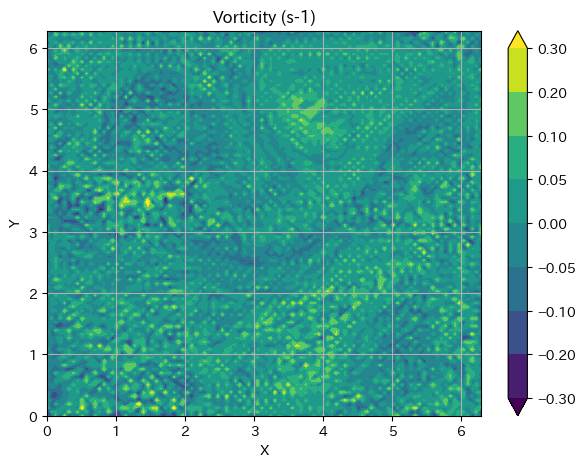

In [4]:
#-- Drawing
##########
#  Plot  #
##########
using PyPlot

rc("font", family="IPAPGothic")
fig = figure("pyplot_majorminor",figsize=(7,5))

xax = reshape(zeros(nx,ny),nx,ny)
yax = reshape(zeros(nx,ny),nx,ny)

for i in 1:nx
    xax[i,1:ny] .= xmin + (xmax-xmin) * (i-1) / (nx-1)
end
for i in 1:ny
    yax[1:nx,i] .= ymin + (ymax-ymin) * (i-1) / (ny-1)
end

a1 = 1.0
b1 = 2.0
#psi .= a1 .* sin.(k .* xax .+ l .* yax) .+ b1 .* cos.(k .* xax .+ l .* yax)

for i in 1:(nt÷dmpitv)+1
#draw_num2 = 2
#if draw_num2 == 1
#    cp = contourf(xax[1:nx,1:nx], xax'[1:nx,1:nx], Pftime[1:nx,1:nx,1], levels=[-15.0, -10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0], origin="image", cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:nx], xax'[1:nx,1:nx], Pftime[1:nx,1:nx,2], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], origin="image", cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:no], xax'[1:nx,1:no], Pftime[1:nx,1:nx,2]*Hop'*inv(Hop*Pftime[1:nx,1:nx,2]*Hop'+Ro), origin="image", cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 2
    cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], zeta_dmp[1:nx,1:ny,i], 8, levels=[-0.3, -0.2, -0.1, -0.05, 0.0, 0.05, 0.1, 0.2, 0.3], cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], zeta_dmp[1:nx,1:ny,i], 10, cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 3
#    cp = contourf(xoax[1:nx,1:nto-1], toax[1:nx,1:nto-1], evec_max[1:nx,1:nto-1], 10, cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 4
#    cp = contourf(xoax[1:nx,1:40], toax[1:nx,1:40], x_inc[1:nx,1:40], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 5
#    cp = contourf(xoax[1:no,1:40], toax[1:no,1:40], y_innov[1:no,1:40], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], cmap=ColorMap("viridis"), extend="both")
#end
#ax.label(cp, inline=1, fontsize=10)
#legend()
ax = gca()

xlabel("X")
ylabel("Y")
if i == 1
   plt.colorbar(cp)
end
grid("on")

PyPlot.title("Vorticity (s-1)")

#########################
#  Set tick dimensions  #
#########################
#ax.xaxis.set_tick_params(which="major",length=5,width=2,labelsize=10)
#ax.xaxis.set_tick_params(which="minor",length=5,width=2)

fig.canvas.draw() # Update the figure
gcf() # Needed for IJulia to plot inline
fname = "QG" * string(i) * ".png"
#savefig("B-init_2d.pdf")
savefig(fname)
#psi
end

In [3]:
# Initial condition
nx = 100
ny = 100
nz = 5
nt = 100
xmin = 0.0
xmax = 1.0
ymin = 0.0
ymax = 1.0
zmin = 0.0
zmax = 1.0

dx = (xmax-xmin) / nx
dy = (ymax-ymin) / ny
dz = (zmax-zmin) / nz
dt = dx

psi = reshape(zeros(nx,ny,nz),nx,ny,nz)
zeta = reshape(zeros(nx,ny,nz),nx,ny,nz)
temp = reshape(zeros(nx,ny,nz),nx,ny,nz)
omega = reshape(zeros(nx,ny,nz),nx,ny,nz)

100×100×5 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [4]:
# Time integration

In [5]:
using Random
rng = MersenneTwister(1234)
for i in 1:100
    println(randn(rng,Float64))
end

0.8673472019512456
-0.9017438158568171
-0.4944787535042339
-0.9029142938652416
0.8644013132535154
2.2118774995743475
0.5328132821695382
-0.27173539603462066
0.5023344963886675
-0.5169836206932686
-0.5605013381807765
-0.019291781689849075
0.12806443451512645
1.852782957725545
-0.8277634318169205
0.11009612632217552
-0.2511757400198831
0.3697140350317453
0.07211635315125874
-1.503429457351051
1.5641682355362416
-1.3967353668333795
1.1054978391059092
-1.1067299135255761
-3.2113596499239088
-0.07401454242444336
0.1509756176321479
0.7692782605345824
-0.31015257323306406
-0.6027068905147959
-1.2796722102183824
0.9973171556575041
0.302422509042974
-0.036445994527206725
0.14197425838484184
0.5212726564680514
0.8967478231916237
-0.5135298961952287
-0.7647985048765796
-1.5414263839472457
-0.0801624859452718
-1.0912192142639132
-0.5805165450434235
-0.3154372460983286
-1.3614476249361172
-0.11445720023473198
0.1658369675157237
-0.40843803219265074
-1.009783518501397
-0.5438048486401967
-1.22672472

[memo]
# 4D-VAR vs EnKF
* 4D-VAR ha window zentai wo mottomo kansoku ni awaseru youni kaiseki suru.
* EnKF ha kansoku yori saki (mirai) no zyoutai wo syuusei suru
* izyou yori, syoki zikoku ni tikai zyoutai deha 4D-VAR no houga EnKF yori yoi seiseki tonaru.

* seido wo 2x ni sitakereba, ensemble member number ha 4x
* Locarization ga member number wo huyasita koto ni taiou suru

* smoother: mirai no kansoku de kako wo kaiseki suru (kaiseki time < kansoku time)
* filter: kako no kansoku de mirai wo kaiseki suru (kaiseki time > kansoku time)